# Covid Impact Analysis


In [27]:
import numpy as np
import pandas as pd
import censusdata
from tabulate import tabulate
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150 #set figure size

from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
#import plotly.plotly as py
import plotly.graph_objs as go
from us_state import *
import plotly.figure_factory as ff
import networkx as nx


## Download Census Dataset

Referrencing https://towardsdatascience.com/mapping-us-census-data-with-python-607df3de4b9c:
* ‘acs5’ refers to the 5 Year American Community Survey and designates the database we are downloading from.
* 2015 is the year that we are getting data from
* censusdata.censusgeo([(‘state’, ‘36’), (‘county’, ‘*’)]) defines the geography we are interested in. The ‘36’ value is the FIPS (Federal Information Processing Standards) code for New York state while the ‘*’ means we want every county. To look up your own state or county FIPS code refer to the Wikipedia page.
* [‘B08301_001E’, ‘B08301_010E’] this is a list referring to the specific two tables that we are interested in. Note that these were located beforehand using the search function of censusdata.


In [2]:
census = censusdata.download('acs5', 2015,
           censusdata.censusgeo([('state', '*'), ('county', '*')]),
           ['B08301_001E', 'B08301_010E'])

In [3]:
census.head()

,B08301_001E,B08301_010E
"Childress County, Texas: Summary level: 050, state:48> county:075",2517,0
"Comal County, Texas: Summary level: 050, state:48> county:091",53161,41
"Houston County, Texas: Summary level: 050, state:48> county:225",7570,3
"Navarro County, Texas: Summary level: 050, state:48> county:349",19513,10
"Scurry County, Texas: Summary level: 050, state:48> county:415",7324,68


In [4]:
#process the dataframe
column_names = ['total_transpo', 'total_public_transpo']
census.columns = column_names
census['percent_public_transpo'] = census.apply(
   lambda row: row['total_public_transpo']/row['total_transpo'], axis = 1)
new_indices = []
county_names = []
state = []
for index in census.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(',')[0].strip()
        temp = index.name.split(';')[0]
        state_name = index.name.split(',')[1].strip()
        county_names.append(county_name)
        state.append(state_name)
census.index = new_indices
census['county'] = county_names
census['state'] = state

In [5]:
#census['county_name'] = census['county_name'].str.replace(' County', '')
census.head()

,total_transpo,total_public_transpo,percent_public_transpo,county,state
48075,2517,0,0.000000,Childress County,Texas
48091,53161,41,0.000771,Comal County,Texas
48225,7570,3,0.000396,Houston County,Texas
48349,19513,10,0.000512,Navarro County,Texas
48415,7324,68,0.009285,Scurry County,Texas


## Download US Covid Dataset
Dataset: https://www.kaggle.com/headsortails/covid19-us-county-jhu-data-demographics

In [6]:
us_covid = pd.read_csv('./data/covid_us_county.csv')
us_county = pd.read_csv('./data/us_county.csv')
print('Covid dataset is updated to:',max(us_covid.date))

Covid dataset is updated to: 2021-05-10


In [7]:
us_covid.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


In [8]:
us_county.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730
1,1003,Baldwin County,Alabama,AL,101188,106919,42.8,208107,51.376936,30.727479,-87.722564
2,1005,Barbour County,Alabama,AL,13697,12085,39.9,25782,46.873788,31.869581,-85.393210
3,1007,Bibb County,Alabama,AL,12152,10375,39.9,22527,46.055844,32.998628,-87.126475
4,1009,Blount County,Alabama,AL,28434,29211,40.8,57645,50.673953,33.980869,-86.567380


In [9]:
#Merge us_county and census dataset
us_county['state'] = us_county['state_code'].map(abbrev_us_state)
df = pd.merge(census, us_county, on=["state","county",])
print('us_county data shape before merge:',us_county.shape)
print('census data shape before merge:',census.shape)
print('Joining by State and County:',df.shape)

us_county data shape before merge: (3220, 11)
census data shape before merge: (3220, 5)
Joining by State and County: (3140, 14)


In [10]:
df.head()

,total_transpo,total_public_transpo,percent_public_transpo,county,state,fips,state_code,male,female,median_age,population,female_percentage,lat,long
0,2517,0,0.000000,Childress County,Texas,48075,TX,4449,2777,30.9,7226,38.430667,34.529140,-100.207618
1,53161,41,0.000771,Comal County,Texas,48091,TX,66793,68304,42.0,135097,50.559228,29.808186,-98.278270
2,7570,3,0.000396,Houston County,Texas,48225,TX,12432,10523,44.0,22955,45.841865,31.317733,-95.422681
3,19513,10,0.000512,Navarro County,Texas,48349,TX,23845,24738,38.6,48583,50.919046,32.046926,-96.472475
4,7324,68,0.009285,Scurry County,Texas,48415,TX,9425,7814,36.1,17239,45.327455,32.746283,-100.916430


In [15]:
df_ny = df[df['state_code']=='NY']

## Network Graph
Referrencing: https://towardsdatascience.com/census-geography-with-networkx-fe2aa6c8ab16

County Adjacency Dataset: https://data.nber.org/data/county-adjacency.html

* Nodes — Each node will represent and individual county in New York state. They will be identified by their FIPS (Federal Information Processing Standards) number. Additionally, each node will store the natural language name of the County as well as the % use of public transit.
* Edges — Two nodes will share an edge if they are geographically adjacent on the map


In [88]:
def process_counties(df):
    final_list = []
    for index, row in df.iterrows():
        node = (str(row['fips']), 
          {'percent_public_transpo': row['percent_public_transpo'],
           'county_name': row['county']})
        final_list.append(node)
    return final_list
# We’ll define a function to turn the dataframe into a list of tuples 
# while removing any mirrored or self-joined edges.
def create_tuples(df):
    all_tuples = list(df.itertuples(index=False, name=None))
    final_tuples = []
    for tuple in all_tuples:
        if (tuple[1],tuple[0]) not in final_tuples:
            if tuple[1] != tuple[0]:
                final_tuples.append((str(tuple[0]),str(tuple[1])))
    return final_tuples

def draw_graph(G):
    plt.close()
    nx.draw_spring(G, with_labels=True, font_weight='bold',node_size=200,font_size=8)
    plt.show()
    return

In [89]:
G = nx.Graph()
county_FIPS = process_counties(df_ny)
G.add_nodes_from(county_FIPS)
adj_df = pd.read_csv('./data/county_adjacency2010.csv')
county_FIPS_list = list(df_ny.fips)
adj_df = adj_df[adj_df['fipscounty'].isin(county_FIPS_list)]
adj_df = adj_df[adj_df['fipsneighbor'].isin(county_FIPS_list)]
# remove all columns except the FIPS codes
adj_df = adj_df[['fipscounty', 'fipsneighbor']]
fips_tuples = create_tuples(adj_df)
G.add_edges_from(fips_tuples)

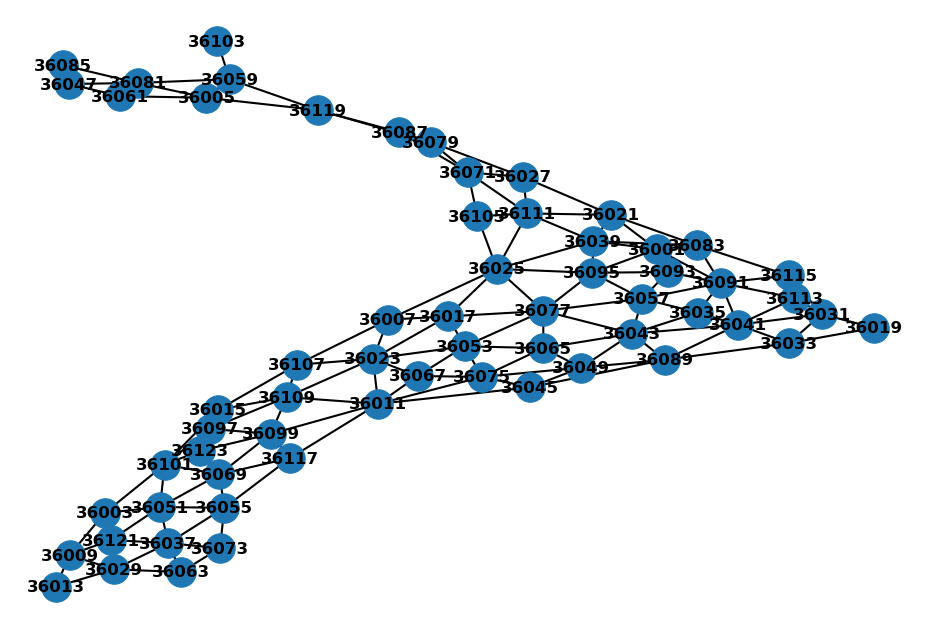

In [90]:
draw_graph(G)

## Mapping

structuring our dataframe in a way that's compatible with figure_factory. For instance, it takes in FIPS data in the form of state_code + county_code. So by renaming our indices to follow that form, we can simply pass the direct index values into the method

In [17]:
fig = ff.create_choropleth(fips=df_ny.fips, 
                           scope=['New York'],
                           values=df_ny.percent_public_transpo, 
                           title='NY Public Transit Use by County', 
                           legend_title='% Public Transit')
fig.layout.template = None
fig.show()

## Deeper Analysis of States
Referrencing: https://www.kaggle.com/headsortails/covid19-us-county-jhu-data-demographics

In [12]:
#fips of 2 counties are missing (Dukes and Nantucket, Kansas City)
#quick fix for now
us_covid = us_covid[us_covid.fips.notnull()]
us_covid['fips'] = us_covid['fips'].astype(object)
us_county['fips'] = us_county['fips'].astype(object)

#add popultation from second csv
us_covid = us_covid.merge(us_county[['fips', 'population']], on = ['fips'], how = "left")

#keep latest date only
us_cum = us_covid.sort_values(by = ['county', 'state', 'date'], ascending = [True, True, False])
us_cum = us_cum.drop_duplicates(subset = ['county', 'state'], keep = "first")

#save a copy
counties_us = us_cum.copy()

#groupby State
us_cum = us_cum.groupby(['state', 'date'], as_index=False)['cases', 'deaths', 'population'].sum()

us_cum['population'] = us_cum['population'].astype(int)

#rounding population to millions with 2 digits, and creating two new columns
us_cum['population'] = round((us_cum['population']/1000000),2)
us_cum = us_cum.rename(columns = {'population': 'Population (million)'})
us_cum['Cases per Million'] = round((us_cum['cases']/us_cum['Population (million)']),2)
us_cum['Deaths per Million'] = round((us_cum['deaths']/us_cum['Population (million)']),2)

#remove states with missing population
us_cum = us_cum[(us_cum['Population (million)'] != 0)]

<ipython-input-12-58b220541b7c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-58b220541b7c>:18: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [13]:
us_cum = us_cum.sort_values(by = "Deaths per Million", ascending = False).reset_index(drop=True)
us_cum.head(10).style.background_gradient(cmap='Reds', subset = ['Deaths per Million'])

,state,date,cases,deaths,Population (million),Cases per Million,Deaths per Million
0,New Jersey,2021-05-10,1008046,25810,8.880000,113518.690000,2906.530000
1,New York,2021-05-10,2074079,52729,19.620000,105712.490000,2687.510000
2,Massachusetts,2021-05-10,695056,17693,6.830000,101765.150000,2590.480000
3,Rhode Island,2021-05-10,149948,2690,1.060000,141460.380000,2537.740000
4,Arizona,2021-05-10,869472,17409,6.950000,125103.880000,2504.890000
5,Mississippi,2021-05-10,313675,7234,2.990000,104908.030000,2419.400000
6,South Dakota,2021-05-10,123310,1981,0.860000,143383.720000,2303.490000
7,Connecticut,2021-05-10,343545,8154,3.580000,95962.290000,2277.650000
8,Alabama,2021-05-10,531094,10978,4.860000,109278.600000,2258.850000
9,Louisiana,2021-05-10,462868,10438,4.660000,99327.900000,2239.910000
